In [32]:
import logging

import numpy as np
import optimistix as optx
from atmodeller import (
    InteriorAtmosphere,
    Planet,
    Species,
    SpeciesCollection,
    debug_logger,
    earth_oceans_to_hydrogen_mass,
    SolverParameters,
)
from atmodeller.eos import get_eos_models
from atmodeller.solubility import get_solubility_models
from atmodeller.thermodata import IronWustiteBuffer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import LogNorm

from scipy.interpolate import interp1d
import os

from matplotlib.ticker import ScalarFormatter

formatter = ScalarFormatter(useMathText=False)
formatter.set_scientific(False)
formatter.set_useOffset(False)
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

logger = debug_logger()
logger.setLevel(logging.INFO)

# For more output use DEBUG
# logger.setLevel(logging.DEBUG)

## Data of Uranus

In [2]:
number_of_realisations = 500
surface_temperature = 5000  # K -> take another temperature, the one aligning with mbe, up to 2-3k kelvin, see if well calibrated for solu and eos

# For simulations with fixed mass and surface radius:
planet_mass = 8e25 #13.4 earth masses for inside boundary 
surface_radius = 2.5559e7  # Lindal et al -> Can be discussed, radius of magma envelope boundary -> reduce and deal with incostitent between rocky and ice planets
#will iterate over later, take for now 0.8 r_U (I find results of 0.4-0.9). r_U = 2.5559e7 take boundary rocky interior and envelopoe
mantle_melt_fraction = 1.0  # 0.1 -> we will iterate 

RANDOM_SEED = 0
np.random.seed(RANDOM_SEED)

#mass constraints given ->

# Abundances

In [3]:
# Palme and O'Neill (2014) Treatise on Geochemistry - Table 3 -> we will adapt for Uranus though
#Take Earth, how much SiO2 -> 14.5 percent times Uranus for Si -> rocky interior (simple assumption)
SiO2_mantlemasspercent_palme14: float = 7.5 #(5-10)
total_mantlemasspercent_palme14: float = 85
core_mass_fraction: float = 0.150  # typical values used are between 0.1-0.2 -> recheck if you took the right one, probably higher (Fe ->Silicates -> envelope)
Si_massfraction_palme14: float = round(
    SiO2_mantlemasspercent_palme14
    / total_mantlemasspercent_palme14
    * (1 - core_mass_fraction)
    / (28.0855 + 2 * 15.999)
    * 28.0855,
    3,
)
print(Si_massfraction_palme14)
O_massfraction_palme14: float = Si_massfraction_palme14 / 28.0855 * 2 * 15.999
# Lodders et al. (2009) Springer Book Chapter - Table 8 (in wt%)

H_masspercent_lodders09: float = 73.9
He_masspercent_lodders09: float = 24.69
C_masspercent_lodders09: float = 0.22
N_masspercent_lodders09: float = 0.07
O_masspercent_lodders09: float = 0.63
Si_masspercent_lodders09: float = 0.07


# Lodders et al. (2009) Springer Book Chapter - Table 6 (log-normalalized abundances relative to H)

H_logN: float = 12
He_logN: float = 10.93
C_logN: float = 8.39
N_logN: float = 7.86
O_logN: float = 8.73
Si_logN: float = 7.53

0.035


# Setup

In [15]:
eos_models = get_eos_models()
sol_models = get_solubility_models()

H2O_g = Species.create_gas("H2O")
H2O_gs = Species.create_gas("H2O", solubility=sol_models["H2O_peridotite_sossi23"])
H2O_rgs = Species.create_gas(
    "H2O",
    activity=eos_models["H2O_cork_holland98"],
    solubility=sol_models["H2O_peridotite_sossi23"],
)

H2_g = Species.create_gas("H2")
H2_gs = Species.create_gas("H2", solubility=sol_models["H2_basalt_hirschmann12"])
H2_rgs = Species.create_gas(
    "H2", activity=eos_models["H2_chabrier21"], solubility=sol_models["H2_basalt_hirschmann12"]
)

O2_g = Species.create_gas("O2")
O2_rg = Species.create_gas("O2", activity=eos_models["O2_cs_shi92"])

OSi_g = Species.create_gas("OSi")
OSi_rg = Species.create_gas("OSi", activity=eos_models["OSi_rk49_connolly16"])

H4Si_g = Species.create_gas("H4Si")
H4Si_rg = Species.create_gas("H4Si", activity=eos_models["H4Si_wang18"])

O2Si_l = Species.create_condensed("O2Si", state="l")
O2Si_bqz = Species.create_condensed("O2Si", state="bqz")

species_HOSi_magma_nosol_ideal = SpeciesCollection((H2O_g, H2_g, O2_g, OSi_g, H4Si_g, O2Si_l))
species_HOSi_magma_sol_ideal = SpeciesCollection((H2O_gs, H2_gs, O2_g, OSi_g, H4Si_g, O2Si_l))
species_HOSi_magma_sol_real = SpeciesCollection((H2O_rgs, H2_rgs, O2_rg, OSi_rg, H4Si_rg, O2Si_l))

In [16]:
hmps = np.logspace(-1, 0, num=number_of_realisations)  # wt%
h_kgs = hmps / 100 * planet_mass  # kg
si_kg_magma: float = Si_massfraction_palme14 * planet_mass 
o_kg_magma: float = O_massfraction_palme14 * planet_mass
si_kgs_solar = h_kgs * Si_masspercent_lodders09 / H_masspercent_lodders09
o_kgs_solar = h_kgs * O_masspercent_lodders09 / H_masspercent_lodders09

In [17]:
init_metallicity = 1

Uranus = Planet(
    surface_temperature=surface_temperature,
    planet_mass=planet_mass,
    surface_radius=surface_radius,
    mantle_melt_fraction=mantle_melt_fraction,
)

mass_constraints = {
    "Si": si_kg_magma * mantle_melt_fraction,
    "O": o_kg_magma * mantle_melt_fraction,
    "H": h_kgs,
}

In [18]:
#No sol - Ideal 
model_ideal_nosol = InteriorAtmosphere(species_HOSi_magma_nosol_ideal)

model_ideal_nosol.solve(
    planet=Uranus,
    mass_constraints=mass_constraints,
)
output_ideal_nosol = model_ideal_nosol.output

output_ideal_nosol.quick_look()

output_ideal_nosol.to_excel("Uranus_ideal_nosol")

[15:12:58 - atmodeller.classes             - INFO     ] - species = ('H2O_g: IdealGas, NoSolubility', 'H2_g: IdealGas, NoSolubility', 'O2_g: IdealGas, NoSolubility', 'OSi_g: IdealGas, NoSolubility', 'H4Si_g: IdealGas, NoSolubility', 'O2Si_l: CondensateActivity, NoSolubility')
[15:12:58 - atmodeller.classes             - INFO     ] - reactions = {0: '2.0 H2O_g = 2.0 H2_g + 1.0 O2_g',
 1: '3.0 H2_g + 1.0 OSi_g = 1.0 H2O_g + 1.0 H4Si_g',
 2: '1.0 H2O_g + 1.0 OSi_g = 1.0 H2_g + 1.0 O2Si_l'}
[15:12:58 - atmodeller.classes             - INFO     ] - Attempting to solve 500 model(s)
[15:12:58 - atmodeller.classes             - INFO     ] - Solve complete: 500 (100.00%) successful model(s)
[15:12:58 - atmodeller.classes             - INFO     ] - Solver steps (max) = 62
[15:12:58 - atmodeller.output              - INFO     ] - Writing output to excel
[15:12:58 - atmodeller.output              - INFO     ] - Computing to_dataframes output
[15:12:58 - atmodeller.output              - INFO     ] 

In [20]:
#Sol ideal 
model_ideal_sol = InteriorAtmosphere(species_HOSi_magma_sol_ideal)

initial_log_number_density = output_ideal_nosol.log_number_density
model_ideal_sol.solve(
    planet=Uranus,
    mass_constraints=mass_constraints,
    initial_log_number_density=initial_log_number_density,
)
output_ideal_sol = model_ideal_sol.output

output_ideal_sol.quick_look()

output_ideal_sol.to_excel("Uranus_ideal_sol")

[15:16:03 - atmodeller.classes             - INFO     ] - species = ('H2O_g: IdealGas, SolubilityPowerLaw', 'H2_g: IdealGas, SolubilityPowerLawLog10', 'O2_g: IdealGas, NoSolubility', 'OSi_g: IdealGas, NoSolubility', 'H4Si_g: IdealGas, NoSolubility', 'O2Si_l: CondensateActivity, NoSolubility')
[15:16:03 - atmodeller.classes             - INFO     ] - reactions = {0: '2.0 H2O_g = 2.0 H2_g + 1.0 O2_g',
 1: '3.0 H2_g + 1.0 OSi_g = 1.0 H2O_g + 1.0 H4Si_g',
 2: '1.0 H2O_g + 1.0 OSi_g = 1.0 H2_g + 1.0 O2Si_l'}
[15:16:03 - atmodeller.classes             - INFO     ] - Attempting to solve 500 model(s)
[15:16:03 - atmodeller.classes             - INFO     ] - Solve complete: 500 (100.00%) successful model(s)
[15:16:03 - atmodeller.classes             - INFO     ] - Solver steps (max) = 54
[15:16:04 - atmodeller.output              - INFO     ] - Writing output to excel
[15:16:04 - atmodeller.output              - INFO     ] - Computing to_dataframes output
[15:16:04 - atmodeller.output          

In [26]:
import os
os.environ["JAX_DISABLE_JIT"] = "1"

#Real ideal 
model_real_sol = InteriorAtmosphere(species_HOSi_magma_sol_real)

initial_log_number_density = output_ideal_sol.log_number_density

model_real_sol.solve(
    planet=Uranus,
    mass_constraints=mass_constraints,
    initial_log_number_density=initial_log_number_density,
)
print(model_real_sol)
output_real_sol = model_real_sol.output

output_real_sol.quick_look()

output_real_sol.to_excel("Uranus_real_sol")


[15:46:03 - atmodeller.classes             - INFO     ] - species = ('H2O_g: CombinedRealGas, SolubilityPowerLaw', 'H2_g: CombinedRealGas, SolubilityPowerLawLog10', 'O2_g: CombinedRealGas, NoSolubility', 'OSi_g: CombinedRealGas, NoSolubility', 'H4Si_g: CombinedRealGas, NoSolubility', 'O2Si_l: CondensateActivity, NoSolubility')
[15:46:03 - atmodeller.classes             - INFO     ] - reactions = {0: '2.0 H2O_g = 2.0 H2_g + 1.0 O2_g',
 1: '3.0 H2_g + 1.0 OSi_g = 1.0 H2O_g + 1.0 H4Si_g',
 2: '1.0 H2O_g + 1.0 OSi_g = 1.0 H2_g + 1.0 O2Si_l'}
[15:46:03 - atmodeller.classes             - INFO     ] - Attempting to solve 500 model(s)


EquinoxRuntimeError: Above is the stack outside of JIT. Below is the stack inside of JIT:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/mathias/atmodeller/.venv/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/mathias/atmodeller/.venv/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/home/mathias/atmodeller/.venv/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start
    self.io_loop.start()
  File "/home/mathias/atmodeller/.venv/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 211, in start
    self.asyncio_loop.run_forever()
  File "/home/mathias/anaconda3/lib/python3.12/asyncio/base_events.py", line 639, in run_forever
    self._run_once()
  File "/home/mathias/anaconda3/lib/python3.12/asyncio/base_events.py", line 1985, in _run_once
    handle._run()
  File "/home/mathias/anaconda3/lib/python3.12/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/mathias/atmodeller/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 519, in dispatch_queue
    await self.process_one()
  File "/home/mathias/atmodeller/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 508, in process_one
    await dispatch(*args)
  File "/home/mathias/atmodeller/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 400, in dispatch_shell
    await result
  File "/home/mathias/atmodeller/.venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 368, in execute_request
    await super().execute_request(stream, ident, parent)
  File "/home/mathias/atmodeller/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 767, in execute_request
    reply_content = await reply_content
                    ^^^^^^^^^^^^^^^^^^^
  File "/home/mathias/atmodeller/.venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 455, in do_execute
    res = shell.run_cell(
          ^^^^^^^^^^^^^^^
  File "/home/mathias/atmodeller/.venv/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 577, in run_cell
    return super().run_cell(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mathias/atmodeller/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3116, in run_cell
    result = self._run_cell(
             ^^^^^^^^^^^^^^^
  File "/home/mathias/atmodeller/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3171, in _run_cell
    result = runner(coro)
             ^^^^^^^^^^^^
  File "/home/mathias/atmodeller/.venv/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner
    coro.send(None)
  File "/home/mathias/atmodeller/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3394, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mathias/atmodeller/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3639, in run_ast_nodes
    if await self.run_code(code, result, async_=asy):
       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mathias/atmodeller/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3699, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_648/4003740009.py", line 17, in <module>
    model_real_sol.solve(
  File "/home/mathias/atmodeller/atmodeller/classes.py", line 142, in solve
    solution, solver_status, solver_steps = self._solver(base_solution_array, parameters)
                                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mathias/atmodeller/.venv/lib/python3.12/site-packages/equinox/_module/_prebuilt.py", line 81, in __call__
    return self.func(*self.args, *args, **kwargs, **self.keywords)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mathias/atmodeller/atmodeller/solvers.py", line 59, in solver_single
    sol: optx.Solution = optx.root_find(
                         ^^^^^^^^^^^^^^^
  File "/home/mathias/atmodeller/.venv/lib/python3.12/site-packages/optimistix/_root_find.py", line 220, in root_find
    return iterative_solve(
           ^^^^^^^^^^^^^^^^
  File "/home/mathias/atmodeller/.venv/lib/python3.12/site-packages/optimistix/_iterate.py", line 346, in iterative_solve
    ) = adjoint.apply(_iterate, rewrite_fn, inputs, tags)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mathias/atmodeller/.venv/lib/python3.12/site-packages/equinox/_module/_prebuilt.py", line 33, in __call__
    return self.__func__(self.__self__, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mathias/atmodeller/.venv/lib/python3.12/site-packages/optimistix/_adjoint.py", line 134, in apply
    return implicit_jvp(primal_fn, rewrite_fn, inputs, tags, self.linear_solver)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mathias/atmodeller/.venv/lib/python3.12/site-packages/optimistix/_ad.py", line 60, in implicit_jvp
    root, residual = _implicit_impl(fn_primal, fn_rewrite, inputs, tags, linear_solver)
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mathias/atmodeller/.venv/lib/python3.12/site-packages/optimistix/_ad.py", line 67, in _implicit_impl
    return jtu.tree_map(jnp.asarray, fn_primal(inputs))
                                     ^^^^^^^^^^^^^^^^^
  File "/home/mathias/atmodeller/.venv/lib/python3.12/site-packages/optimistix/_iterate.py", line 242, in _iterate
    final_carry = while_loop(cond_fun, body_fun, init_carry, max_steps=max_steps)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mathias/atmodeller/.venv/lib/python3.12/site-packages/equinox/internal/_loop/loop.py", line 103, in while_loop
    _, _, _, final_val = lax.while_loop(cond_fun_, body_fun_, init_val_)
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mathias/atmodeller/.venv/lib/python3.12/site-packages/equinox/internal/_loop/common.py", line 474, in new_body_fun
    buffer_val2 = body_fun(buffer_val)
                  ^^^^^^^^^^^^^^^^^^^^
  File "/home/mathias/atmodeller/.venv/lib/python3.12/site-packages/optimistix/_iterate.py", line 232, in body_fun
    new_y, new_state, aux = solver.step(fn, y, args, options, state, tags)
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mathias/atmodeller/.venv/lib/python3.12/site-packages/equinox/_module/_prebuilt.py", line 33, in __call__
    return self.__func__(self.__self__, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mathias/atmodeller/.venv/lib/python3.12/site-packages/optimistix/_solver/newton_chord.py", line 117, in step
    fx, lin_fn, aux = jax.linearize(lambda _y: fn(_y, args), y, has_aux=True)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mathias/atmodeller/.venv/lib/python3.12/site-packages/optimistix/_solver/newton_chord.py", line 117, in <lambda>
    fx, lin_fn, aux = jax.linearize(lambda _y: fn(_y, args), y, has_aux=True)
                                               ^^^^^^^^^^^^
  File "/home/mathias/anaconda3/lib/python3.12/contextlib.py", line 81, in inner
    return func(*args, **kwds)
           ^^^^^^^^^^^^^^^^^^^
  File "/home/mathias/anaconda3/lib/python3.12/contextlib.py", line 81, in inner
    return func(*args, **kwds)
           ^^^^^^^^^^^^^^^^^^^
  File "/home/mathias/anaconda3/lib/python3.12/contextlib.py", line 81, in inner
    return func(*args, **kwds)
           ^^^^^^^^^^^^^^^^^^^
  File "/home/mathias/atmodeller/.venv/lib/python3.12/site-packages/optimistix/_ad.py", line 110, in _implicit_impl_jvp
    t_root = (-(lx.linear_solve(operator, jvp_diff, linear_solver).value ** ω)).ω
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mathias/atmodeller/.venv/lib/python3.12/site-packages/lineax/_solve.py", line 820, in linear_solve
    solution, result, stats = eqxi.filter_primitive_bind(
                              ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mathias/atmodeller/.venv/lib/python3.12/site-packages/equinox/internal/_primitive.py", line 273, in filter_primitive_bind
    flat_out = prim.bind(*dynamic, treedef=treedef, static=static, flatten=flatten)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mathias/atmodeller/.venv/lib/python3.12/site-packages/equinox/internal/_primitive.py", line 156, in _wrapper
    out = rule(*args)
          ^^^^^^^^^^^
  File "/home/mathias/atmodeller/.venv/lib/python3.12/site-packages/lineax/_solve.py", line 126, in _linear_solve_abstract_eval
    out = eqx.filter_eval_shape(
          ^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mathias/atmodeller/.venv/lib/python3.12/site-packages/lineax/_solve.py", line 114, in _linear_solve_impl
    solution, result, stats = result.error_if(
                              ^^^^^^^^^^^^^^^^
  File "/home/mathias/atmodeller/.venv/lib/python3.12/site-packages/equinox/_module/_prebuilt.py", line 33, in __call__
    return self.__func__(self.__self__, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

equinox.EquinoxRuntimeError: A linear solver received non-finite (NaN or inf) input and cannot determine a 
solution. 

This means that you have a bug upstream of Lineax and should check the inputs to 
`lineax.linear_solve` for non-finite values.

-------------------

An error occurred during the runtime of your JAX program.

1) Setting the environment variable `EQX_ON_ERROR=breakpoint` is usually the most useful
way to debug such errors. This can be interacted with using most of the usual commands
for the Python debugger: `u` and `d` to move up and down frames, the name of a variable
to print its value, etc.

2) You may also like to try setting `JAX_DISABLE_JIT=1`. This will mean that you can
(mostly) inspect the state of your program as if it was normal Python.

3) See `https://docs.kidger.site/equinox/api/debug/` for more suggestions.


# Plots

In [27]:
color_tot = "black"
color_H2 = "orange"
color_H2O = "blue"
color_SiH4 = "red"
color_SiO = "brown"
color_O2 = "limegreen"
color_H = "orange"
color_O = "blue"
color_Si = "red"

In [28]:
filename = "Uranus_ideal_sol.xlsx"

In [29]:
H2_pressure_magma_sol_real = pd.read_excel(filename, sheet_name="H2_g")["pressure"]
H2O_pressure_magma_sol_real = pd.read_excel(filename, sheet_name="H2O_g")["pressure"]
O2_pressure_magma_sol_real = pd.read_excel(filename, sheet_name="O2_g")["pressure"]
SiH4_pressure_magma_sol_real = pd.read_excel(filename, sheet_name="H4Si_g")["pressure"]
SiO_pressure_magma_sol_real = pd.read_excel(filename, sheet_name="OSi_g")["pressure"]
tot_pressure_magma_sol_real = pd.read_excel(filename, sheet_name="atmosphere")["pressure"]

H_moles_atm_magma_sol_real = pd.read_excel(filename, sheet_name="element_H")["atmosphere_moles"]
O_moles_atm_magma_sol_real = pd.read_excel(filename, sheet_name="element_O")["atmosphere_moles"]
Si_moles_atm_magma_sol_real = pd.read_excel(filename, sheet_name="element_Si")["atmosphere_moles"]

H_moles_melt_magma_sol_real = pd.read_excel(filename, sheet_name="element_H")["dissolved_moles"]
O_moles_melt_magma_sol_real = pd.read_excel(filename, sheet_name="element_O")["dissolved_moles"]
Si_moles_melt_magma_sol_real = pd.read_excel(filename, sheet_name="element_Si")["dissolved_moles"]

H_moles_tot_magma_sol_real = pd.read_excel(filename, sheet_name="element_H")["total_moles"]
O_moles_tot_magma_sol_real = pd.read_excel(filename, sheet_name="element_O")["total_moles"]
Si_moles_tot_magma_sol_real = pd.read_excel(filename, sheet_name="element_Si")["total_moles"]

H_mass_atm_magma_sol_real = pd.read_excel(filename, sheet_name="element_H")["atmosphere_mass"]
O_mass_atm_magma_sol_real = pd.read_excel(filename, sheet_name="element_O")["atmosphere_mass"]
Si_mass_atm_magma_sol_real = pd.read_excel(filename, sheet_name="element_Si")["atmosphere_mass"]

H_mass_melt_magma_sol_real = pd.read_excel(filename, sheet_name="element_H")["dissolved_mass"]
O_mass_melt_magma_sol_real = pd.read_excel(filename, sheet_name="element_O")["dissolved_mass"]
Si_mass_melt_magma_sol_real = pd.read_excel(filename, sheet_name="element_Si")["dissolved_mass"]

H_mass_tot_magma_sol_real = pd.read_excel(filename, sheet_name="element_H")["total_mass"]
O_mass_tot_magma_sol_real = pd.read_excel(filename, sheet_name="element_O")["total_mass"]
Si_mass_tot_magma_sol_real = pd.read_excel(filename, sheet_name="element_Si")["total_mass"]

H2_fc_magma_sol_real = pd.read_excel(filename, sheet_name="H2_g")["fugacity_coefficient"]
H2O_fc_magma_sol_real = pd.read_excel(filename, sheet_name="H2O_g")["fugacity_coefficient"]
O2_fc_magma_sol_real = pd.read_excel(filename, sheet_name="O2_g")["fugacity_coefficient"]
SiH4_fc_magma_sol_real = pd.read_excel(filename, sheet_name="H4Si_g")["fugacity_coefficient"]
SiO_fc_magma_sol_real = pd.read_excel(filename, sheet_name="OSi_g")["fugacity_coefficient"]

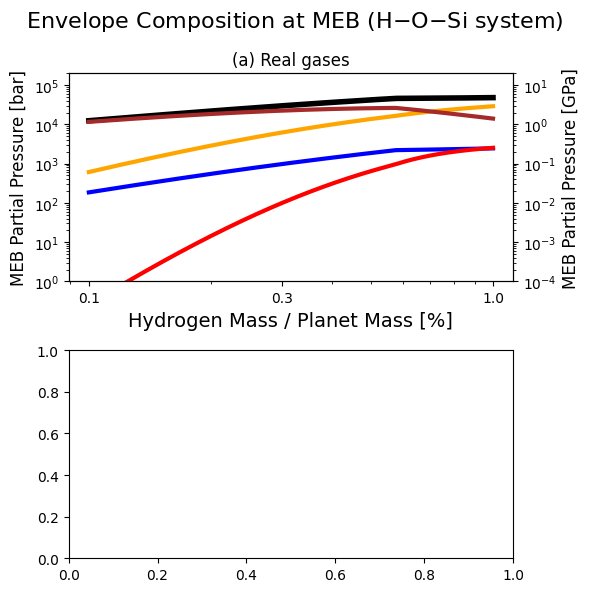

In [34]:
fig, (ax0, ax1) = plt.subplots(2, figsize=(6, 6), tight_layout="True")


ax0.plot(hmps, tot_pressure_magma_sol_real, color=color_tot, lw=4, ls="-", label="Total")
ax0.plot(hmps, H2_pressure_magma_sol_real, color=color_H2, lw=3, ls="-", label="H$_2$")
ax0.plot(hmps, H2O_pressure_magma_sol_real, color=color_H2O, lw=3, ls="-", label="H$_2$O")
ax0.plot(hmps, SiH4_pressure_magma_sol_real, color=color_SiH4, lw=3, ls="-", label="SiH$_4$")
ax0.plot(hmps, SiO_pressure_magma_sol_real, color=color_SiO, lw=3, ls="-", label="SiO")
# ax0.plot(hmps, O2_pressure_magma_sol_real, color=color_O2, lw=3, ls= '-', label='O$_2$')

ax0.set_title(r"(a) Real gases")
ax0.set_ylim([1e0, 2e5])
ax0.set_xscale("log")
ax0.set_yscale("log")
ax0.set_xlabel(r"Hydrogen Mass / Planet Mass [%]", fontsize=14)
ax0.set_ylabel(r"MEB Partial Pressure [bar]", fontsize=12)
ax0.set_xticks([0.1, 0.3, 1])
ax0.get_xaxis().set_major_formatter(ScalarFormatter())

ax00 = ax0.twinx()
ax00.set_yscale("log")
ax00.set_ylabel(r"MEB Partial Pressure [GPa]", fontsize=12)
ax00.set_ylim([1e-4, 2e1])

fig.suptitle(f"Envelope Composition at MEB (H$-$O$-$Si system)", fontsize=16)

plt.savefig(f"HOSi_envelope.pdf", bbox_inches="tight")
plt.savefig(f"HOSi_envelope.png", bbox_inches="tight")
plt.show()

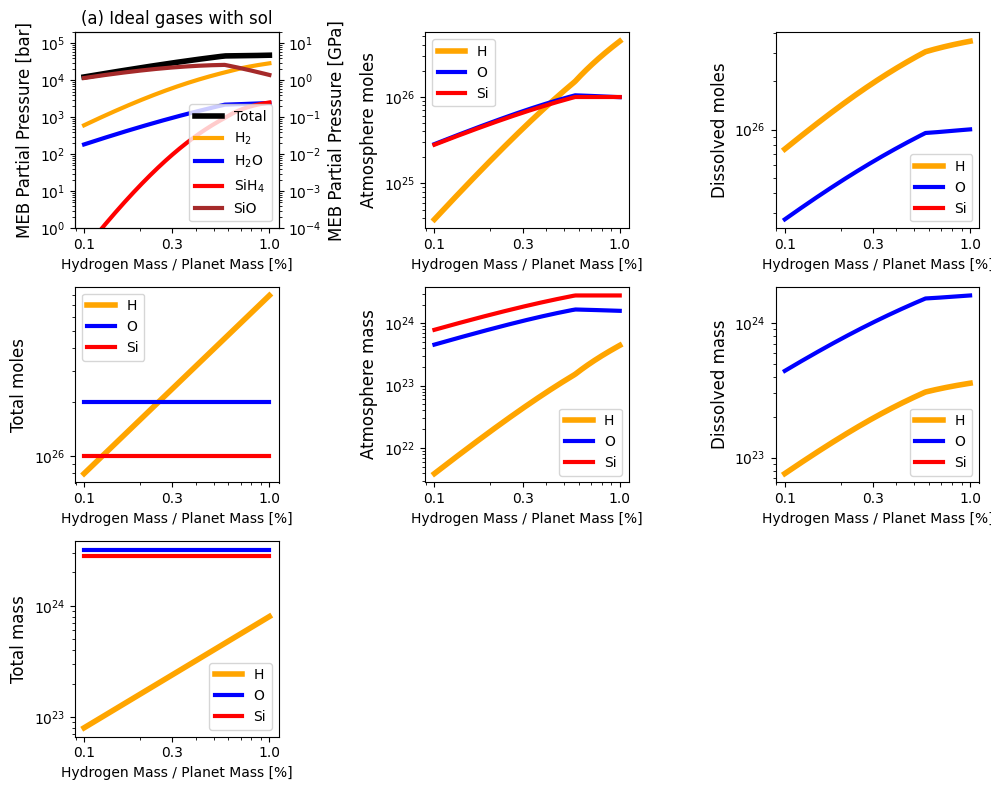

In [51]:
fig, axes = plt.subplots(3, 3, figsize=(10, 8))
axes = axes.flatten()  # flatten 2D array of axes to 1D list

axes[0].plot(hmps, tot_pressure_magma_sol_real, color=color_tot, lw=4, ls="-", label="Total")
axes[0].plot(hmps, H2_pressure_magma_sol_real, color=color_H2, lw=3, ls="-", label="H$_2$")
axes[0].plot(hmps, H2O_pressure_magma_sol_real, color=color_H2O, lw=3, ls="-", label="H$_2$O")
axes[0].plot(hmps, SiH4_pressure_magma_sol_real, color=color_SiH4, lw=3, ls="-", label="SiH$_4$")
axes[0].plot(hmps, SiO_pressure_magma_sol_real, color=color_SiO, lw=3, ls="-", label="SiO")
# ax0.plot(hmps, O2_pressure_magma_sol_real, color=color_O2, lw=3, ls= '-', label='O$_2$')

axes[0].set_title(r"(a) Ideal gases with sol")
axes[0].set_ylim([1e0, 2e5])
axes[0].set_xscale("log")
axes[0].set_yscale("log")
axes[0].set_xlabel(r"Hydrogen Mass / Planet Mass [%]", fontsize=10)
axes[0].set_ylabel(r"MEB Partial Pressure [bar]", fontsize=12)
axes[0].set_xticks([0.1, 0.3, 1])
axes[0].get_xaxis().set_major_formatter(ScalarFormatter())

axes[0].legend(fontsize=10, loc='best') 
ax0 = axes[0].twinx()
ax0.set_yscale("log")
ax0.set_ylabel(r"MEB Partial Pressure [GPa]", fontsize=12)
ax0.set_ylim([1e-4, 2e1])


axes[1].plot(hmps, H_moles_atm_magma_sol_real, color=color_H, lw=4, ls="-", label="H")
axes[1].plot(hmps, O_moles_atm_magma_sol_real, color=color_O, lw=3, ls="-", label="O")
axes[1].plot(hmps, Si_moles_atm_magma_sol_real, color=color_Si, lw=3, ls="-", label="Si")
# ax0.plot(hmps, O2_pressure_magma_sol_real, color=color_O2, lw=3, ls= '-', label='O$_2$')

#axes[1].set_ylim([1e0, 2e5])
axes[1].set_xscale("log")
axes[1].set_yscale("log")
axes[1].set_xlabel(r"Hydrogen Mass / Planet Mass [%]", fontsize=10)
axes[1].set_ylabel("Atmosphere moles", fontsize=12)
axes[1].set_xticks([0.1, 0.3, 1])
axes[1].get_xaxis().set_major_formatter(ScalarFormatter())
axes[1].legend(fontsize=10, loc='best') 


axes[2].plot(hmps, H_moles_melt_magma_sol_real, color=color_H, lw=4, ls="-", label="H")
axes[2].plot(hmps, O_moles_melt_magma_sol_real, color=color_O, lw=3, ls="-", label="O")
axes[2].plot(hmps, Si_moles_melt_magma_sol_real, color=color_Si, lw=3, ls="-", label="Si")
# ax0.plot(hmps, O2_pressure_magma_sol_real, color=color_O2, lw=3, ls= '-', label='O$_2$')

#axes[1].set_ylim([1e0, 2e5])
axes[2].set_xscale("log")
axes[2].set_yscale("log")
axes[2].set_xlabel(r"Hydrogen Mass / Planet Mass [%]", fontsize=10)
axes[2].set_ylabel("Dissolved moles", fontsize=12)
axes[2].set_xticks([0.1, 0.3, 1])
axes[2].get_xaxis().set_major_formatter(ScalarFormatter())
axes[2].legend(fontsize=10, loc='best') 


axes[3].plot(hmps, H_moles_tot_magma_sol_real, color=color_H, lw=4, ls="-", label="H")
axes[3].plot(hmps, O_moles_tot_magma_sol_real, color=color_O, lw=3, ls="-", label="O")
axes[3].plot(hmps, Si_moles_tot_magma_sol_real, color=color_Si, lw=3, ls="-", label="Si")
# ax0.plot(hmps, O2_pressure_magma_sol_real, color=color_O2, lw=3, ls= '-', label='O$_2$')

#axes[1].set_ylim([1e0, 2e5])
axes[3].set_xscale("log")
axes[3].set_yscale("log")
axes[3].set_xlabel(r"Hydrogen Mass / Planet Mass [%]", fontsize=10)
axes[3].set_ylabel("Total moles", fontsize=12)
axes[3].set_xticks([0.1, 0.3, 1])
axes[3].get_xaxis().set_major_formatter(ScalarFormatter())
axes[3].legend(fontsize=10, loc='best') 


axes[4].plot(hmps, H_mass_atm_magma_sol_real, color=color_H, lw=4, ls="-", label="H")
axes[4].plot(hmps, O_mass_atm_magma_sol_real, color=color_O, lw=3, ls="-", label="O")
axes[4].plot(hmps, Si_mass_atm_magma_sol_real, color=color_Si, lw=3, ls="-", label="Si")
# ax0.plot(hmps, O2_pressure_magma_sol_real, color=color_O2, lw=3, ls= '-', label='O$_2$')

#axes[1].set_ylim([1e0, 2e5])
axes[4].set_xscale("log")
axes[4].set_yscale("log")
axes[4].set_xlabel(r"Hydrogen Mass / Planet Mass [%]", fontsize=10)
axes[4].set_ylabel("Atmosphere mass", fontsize=12)
axes[4].set_xticks([0.1, 0.3, 1])
axes[4].get_xaxis().set_major_formatter(ScalarFormatter())
axes[4].legend(fontsize=10, loc='best') 


axes[5].plot(hmps, H_mass_melt_magma_sol_real, color=color_H, lw=4, ls="-", label="H")
axes[5].plot(hmps, O_mass_melt_magma_sol_real, color=color_O, lw=3, ls="-", label="O")
axes[5].plot(hmps, Si_mass_melt_magma_sol_real, color=color_Si, lw=3, ls="-", label="Si")
# ax0.plot(hmps, O2_pressure_magma_sol_real, color=color_O2, lw=3, ls= '-', label='O$_2$')

#axes[1].set_ylim([1e0, 2e5])
axes[5].set_xscale("log")
axes[5].set_yscale("log")
axes[5].set_xlabel(r"Hydrogen Mass / Planet Mass [%]", fontsize=10)
axes[5].set_ylabel("Dissolved mass", fontsize=12)
axes[5].set_xticks([0.1, 0.3, 1])
axes[5].get_xaxis().set_major_formatter(ScalarFormatter())
axes[5].legend(fontsize=10, loc='best') 


axes[6].plot(hmps, H_mass_tot_magma_sol_real, color=color_H, lw=4, ls="-", label="H")
axes[6].plot(hmps, O_mass_tot_magma_sol_real, color=color_O, lw=3, ls="-", label="O")
axes[6].plot(hmps, Si_mass_tot_magma_sol_real, color=color_Si, lw=3, ls="-", label="Si")
# ax0.plot(hmps, O2_pressure_magma_sol_real, color=color_O2, lw=3, ls= '-', label='O$_2$')

#axes[1].set_ylim([1e0, 2e5])
axes[6].set_xscale("log")
axes[6].set_yscale("log")
axes[6].set_xlabel(r"Hydrogen Mass / Planet Mass [%]", fontsize=10)
axes[6].set_ylabel("Total mass", fontsize=12)
axes[6].set_xticks([0.1, 0.3, 1])
axes[6].get_xaxis().set_major_formatter(ScalarFormatter())
axes[6].legend(fontsize=10, loc='best') 

# Hide unused subplots
for j in range(7, 9):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

## Solubitly Models From Atmodeller

In [ ]:
solubility_models = get_solubility_models()
CH4_g = Species.create_gas("CH4", solubility=solubility_models["CH4_basalt_ardia13"])
H2O_g = Species.create_gas("H2O", solubility=solubility_models["H2O_basalt_mitchell17"])
#NH3 being there due to N2
idealspecies_withsols = SpeciesCollection((H2O_g,CH4_g))

## EOS Models From Atmodeller

In [ ]:
eos_models = get_eos_models()
H2O_rg = Species.create_gas(
    "H2O",
    activity=eos_models["H2O_cork_holland98"],
    solubility=solubility_models["H2O_basalt_mitchell17"],
)
H2_rg = Species.create_gas(
    "H2",
    activity=eos_models["H2_chabrier21"],
)
H3N_g, = Species.create_gas("H3N"),
O2_g = Species.create_gas("O2")
He_rg = Species.create_gas(
    "He",
    activity=eos_models["He_chabrier21"],
)
CH4_rg = Species.create_gas(
    "CH4",
    activity=eos_models["CH4_cs_shi92"],
    solubility=solubility_models["CH4_basalt_ardia13"],
)
realspecies_withsols = SpeciesCollection((H2O_rg, H2_rg, He_rg, O2_g, H3N_g, CH4_rg))

## Mass Constraints for Uranus

In [ ]:
# Vary Linearly:

log10_H_frac = np.linspace(1.0, 1.7, number_of_realisations)  # 0.1 to 3% of planet mass
# Fix Values for Linearly Varying Cases:
log10_ch_ratios = np.full(number_of_realisations,-2.1)  # 20-30X Solar

h_kg = ((10**log10_H_frac) / 100) * planet_mass
c_kg = h_kg * 10**log10_ch_ratios
mass_constraints = {
    "H": h_kg,
    "C": c_kg,
}

## Starting simulations

In [ ]:
Uranus = Planet(
    surface_temperature=surface_temperature,
    planet_mass=planet_mass,
    surface_radius=surface_radius,
    mantle_melt_fraction=mantle_melt_fraction,
)

In [ ]:
solver = optx.LevenbergMarquardt
solver_parameters = SolverParameters(solver=solver)

model_ideal_varyHF_withsol = InteriorAtmosphere(idealspecies_withsols)


model_ideal_varyHF_withsol.solve(
    planet=Uranus,
    mass_constraints=mass_constraints,
    solver_parameters=solver_parameters,
)
output_ideal_varyHF_withsol = model_ideal_varyHF_withsol.output

# Write the complete solution to Excel
output_ideal_varyHF_withsol.to_excel("Uranus_ideal_withsol_varyHF")

# Write the data to a pickle file with dataframes
output_ideal_varyHF_withsol.to_pickle("Uranus_ideal_withsol_varyHF")

In [ ]:
solver = optx.LevenbergMarquardt
solver_parameters = SolverParameters(solver=solver)

model_real_varyHF_withsol = InteriorAtmosphere(realspecies_withsols)


model_real_varyHF_withsol.solve(
    planet=Uranus,
    mass_constraints=mass_constraints,
    # Use the ideal solution for the initial guess of the real case
    solver_parameters=solver_parameters,
)
output_real_varyHF_withsol = model_real_varyHF_withsol.output

# Write the complete solution to Excel
output_real_varyHF_withsol.to_excel("Uranus_real_withsol_varyHF")

# Write the data to a pickle file with dataframes
output_real_varyHF_withsol.to_pickle("Uranus_real_withsol_varyHF")